# Part 3: Handling Imbalanced Class

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


Bad key "text.kerning_factor" on line 4 in
C:\Users\sumai\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Load Dataset
Please see the link to know more about the dataset: https://www.kaggle.com/jboysen/mri-and-alzheimers

In [2]:
df = pd.read_csv('preprocessed_oasis_longitudinal.csv')
df = df. drop('Unnamed: 0', axis=1)
df.head()

,Visit,Gender,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1,2,87,14,2.0,27.0,0,1987,0.696,0.883
1,2,2,88,14,2.0,30.0,0,2004,0.681,0.876
2,1,2,75,12,0.0,23.0,1,1678,0.736,1.046
3,2,2,76,12,0.0,28.0,1,1738,0.713,1.010
4,3,2,80,12,0.0,22.0,1,1698,0.701,1.034


In [3]:
features = df.columns.to_list()

## Split Input and Traget Variables

In [4]:
X = df.drop('CDR', axis = 1) 
y = df['CDR']

In [5]:
X.columns

Index(['Visit', 'Gender', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF'], dtype='object')

## Train Test Split

In [6]:
# train_test_split is used to split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state =0)

print("Original shape of dataset: {}".format(df.shape))         # shape of original dataset
print("Shape of training dataset: {}".format(X_train.shape))      # shape of training dataset after split
print("Shape of testing dataset: {}".format(X_test.shape))        # shape of testing dataset after split

Original shape of dataset: (373, 10)
Shape of training dataset: (279, 9)
Shape of testing dataset: (94, 9)


### Defining function for later use

In [7]:
def macro_weighted(y_test, y_hat):
    
    rec = recall_score(y_test, y_hat)
    print ("Recall Score:", round(rec, 4))

    rec_mac = recall_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Recall Score:", round(rec_mac, 4))

    rec_wei = recall_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Recall Score:", round(rec_wei, 4))
    
    print ('------------------------------------------------------')
    
    prec_mac = precision_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of Precision Score:", round(prec_mac, 4))

    prec_wei = precision_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of Precision Score:", round(prec_wei, 4))
    
    print ('------------------------------------------------------')

    f1_mac = f1_score(y_test, y_hat, average = 'macro')
    print ("Macro Average of F1 Score:", round(f1_mac, 4))

    f1_wei = f1_score(y_test, y_hat, average = 'weighted')
    print ("Weighted Average of F1 Score:", round(f1_wei, 4))

In [8]:
def cm():  
    
        print('---------------------------------------------------------------')
        
        data = confusion_matrix(y_test, y_hat)
        df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
        df_cm.index.name = 'Actual'
        df_cm.columns.name = 'Predicted'
        plt.figure(figsize = (6, 4))
        #sns.set(font_scale=1.4) #for label size
        sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font size
        plt.show()
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
        print ("TP: {}, FP: {}, TN: {}, FN: {}".format(tp, fp, tn, fn))

In [9]:
def class_rep():
        
        # Print the precision and recall, among other metrics
        print('---------------------------------------------------------------')
        print(classification_report(y_test, y_hat, digits=3))

### Handling Imbalanced Dataset

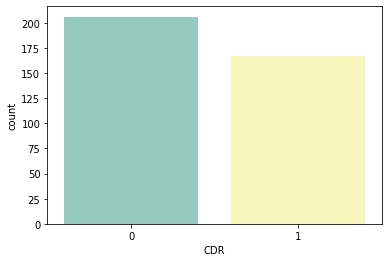

In [10]:
sns.countplot(df['CDR'], palette = "Set3")

#### Resampling Techniques - Oversample Minority Class

Oversampling can be defined as adding more copies of the minority class. In other words, we are creating artificial/synthetic data of the minority class (or group). Oversampling could be a good choice when you don’t have a lot of data to work with. We will use the resampling module from Scikit-Learn library to randomly create artificial samples of data from the minority class.

Recall Score: 0.7805
Macro Average of Recall Score: 0.8336
Weighted Average of Recall Score: 0.8404
------------------------------------------------------
Macro Average of Precision Score: 0.8407
Weighted Average of Precision Score: 0.8405
------------------------------------------------------
Macro Average of F1 Score: 0.8363
Weighted Average of F1 Score: 0.8396
---------------------------------------------------------------


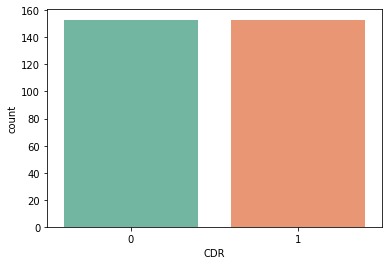

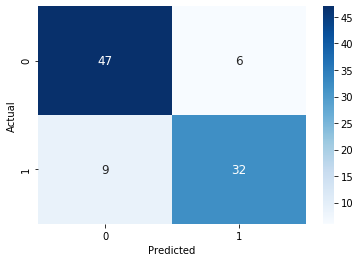

TP: 32, FP: 6, TN: 47, FN: 9
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.839     0.887     0.862        53
           1      0.842     0.780     0.810        41

    accuracy                          0.840        94
   macro avg      0.841     0.834     0.836        94
weighted avg      0.841     0.840     0.840        94



In [11]:
# 'resample' is located under sklearn.utils
from sklearn.utils import resample

# concatenate training data back together
train_data = pd.concat([X_train, y_train], axis = 1)

# separate minority and majority class
not_dem = train_data[train_data['CDR']==0]
dem = train_data[train_data['CDR']==1]

# we are oversampling the minority class to match the number of majority classs
dem_oversampled = resample(dem,
                           replace = True, # Sample with replacement
                           n_samples = len(not_dem), # Match number in majority class
                           random_state=27)

# combine majority and upsampled minority
oversampled = pd.concat([not_dem, dem_oversampled])
sns.countplot(oversampled['CDR'], palette = "Set2")

X_train = oversampled.drop('CDR', axis = 1) 
y_train = oversampled['CDR']

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

model = CatBoostClassifier(logging_level='Silent', random_state = 42)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

macro_weighted(y_test, y_hat)
cm()
class_rep()

#### Generate Synthetic Samples: SMOTE

Here we will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique. SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model. It’s important to generate the new samples only in the training set to ensure our model generalizes well to unseen data.

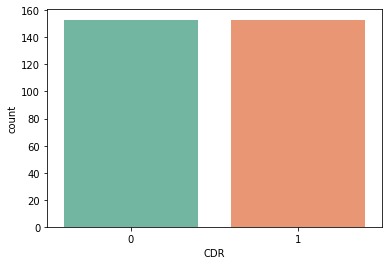

In [12]:
df = pd.read_csv('preprocessed_oasis_longitudinal.csv')
df = df. drop('Unnamed: 0', axis=1)

X = df.drop('CDR', axis = 1) 
y = df['CDR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state =0)

# import SMOTE 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 25, sampling_strategy='auto')   # again we are eqalizing both the classes

# fit the sampling
X_train, y_train = sm.fit_sample(X_train, y_train)
np.unique(y_train, return_counts=True)     # Y_train is numpy array, so unique() functions returns the count of all the unique elements in the array

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

sns.countplot(y_train, palette = "Set2")

Recall Score: 0.8049
Macro Average of Recall Score: 0.8553
Weighted Average of Recall Score: 0.8617
------------------------------------------------------
Macro Average of Precision Score: 0.8628
Weighted Average of Precision Score: 0.8621
------------------------------------------------------
Macro Average of F1 Score: 0.8581
Weighted Average of F1 Score: 0.861
---------------------------------------------------------------


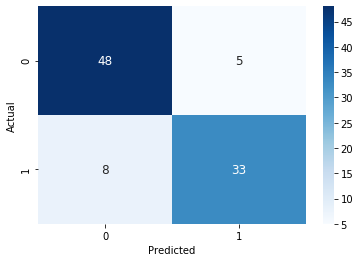

TP: 33, FP: 5, TN: 48, FN: 8
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.857     0.906     0.881        53
           1      0.868     0.805     0.835        41

    accuracy                          0.862        94
   macro avg      0.863     0.855     0.858        94
weighted avg      0.862     0.862     0.861        94



In [13]:
model = CatBoostClassifier(logging_level='Silent', random_state = 42)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

macro_weighted(y_test, y_hat)
cm()
class_rep()

#### SMOTETomek

In [14]:
df = pd.read_csv('preprocessed_oasis_longitudinal.csv')
df = df. drop('Unnamed: 0', axis=1)

X = df.drop('CDR', axis = 1) 
y = df['CDR']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state =0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

The number of classes before fit Counter({0: 153, 1: 126})
The number of classes after fit Counter({0: 140, 1: 136})


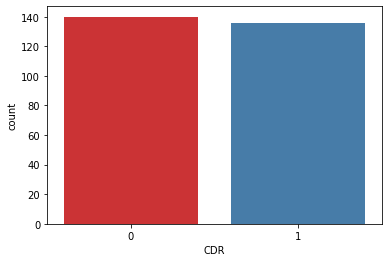

In [15]:
from imblearn.combine import SMOTETomek
from collections import Counter

smot = SMOTETomek(0.98)
X_train_ns, y_train_ns = smot.fit_sample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

sns.countplot(y_train_ns, palette = "Set1")

Recall Score: 0.8049
Macro Average of Recall Score: 0.8553
Weighted Average of Recall Score: 0.8617
------------------------------------------------------
Macro Average of Precision Score: 0.8628
Weighted Average of Precision Score: 0.8621
------------------------------------------------------
Macro Average of F1 Score: 0.8581
Weighted Average of F1 Score: 0.861
---------------------------------------------------------------


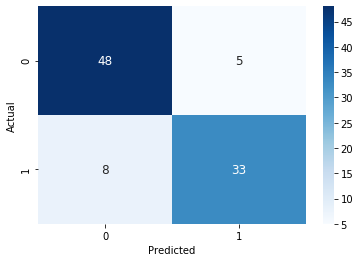

TP: 33, FP: 5, TN: 48, FN: 8
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.857     0.906     0.881        53
           1      0.868     0.805     0.835        41

    accuracy                          0.862        94
   macro avg      0.863     0.855     0.858        94
weighted avg      0.862     0.862     0.861        94



In [16]:
model = CatBoostClassifier(logging_level='Silent', random_state = 42)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)

macro_weighted(y_test, y_hat)
cm()
class_rep()

### We will not create synthetic data in this dataset. Let's find out the best test size.

In [17]:
df = pd.read_csv('preprocessed_oasis_longitudinal.csv')
df = df. drop('Unnamed: 0', axis=1)

X = df.drop('CDR', axis = 1) 
y = df['CDR']

##### Let's try to find the threshold that corresponds to highest f1 score and thus find the best model. Please refer to https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c.

In [18]:
# Let's change test size and see the difference
test_size = list(np.arange(0.15, 0.41, 0.01))

# Let's create a list of threshold value ranging from 0 to 1.
threshold = list(np.arange(0.0, 1, 0.039))

In [19]:
# Now, let's append the threshol and tp, tn, fp, fn values in a DataFrame

tp = []
fp = []
tn = []
fn = []
    
for tt in test_size:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= tt, random_state =0)
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    model = CatBoostClassifier(logging_level='Silent', random_state = 42)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
        
    tn.append(confusion_matrix(y_test, y_hat).ravel()[0]) 
    fp.append(confusion_matrix(y_test, y_hat).ravel()[1])
    fn.append(confusion_matrix(y_test, y_hat).ravel()[2])
    tp.append(confusion_matrix(y_test, y_hat).ravel()[3])
    
results = pd.DataFrame({'threshold': threshold, 'tp' : tp , 'fp': fp, 'tn': tn, 'fn': fn})
results

,threshold,tp,fp,tn,fn
0,0.000,21,4,24,7
1,0.039,22,4,27,7
2,0.078,24,4,29,7
3,0.117,23,4,32,9
4,0.156,25,4,34,8
5,0.195,27,2,37,9
6,0.234,27,3,40,9
7,0.273,30,4,40,9
8,0.312,30,4,43,9
9,0.351,32,4,46,8


In [20]:
def calculate_metrics(results):
    roc = pd.DataFrame(index = results['threshold'], columns=['recall', 'precision', 'f1', 'tpr', 'fpr'])
    
    for i in results.iterrows():
        t, tp, fp, tn, fn = i[1]
        tp + fp + tn + fn == 129
        
        recall = tp / (tp + fn)
        
        if tp == fp == 0:
            precision = 0
            true_positive_rate = 0
        
        else:
            precision = tp / (tp + fp)
            true_positive_rate = tp / (tp + fn)
            
        if precision == recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        
        
        false_positive_rate = fp / (fp + tn)
        
        roc.loc[t, 'recall'] = recall
        roc.loc[t, 'precision'] = precision
        roc.loc[t, 'f1'] = f1
        roc.loc[t, 'tpr'] = true_positive_rate
        roc.loc[t, 'fpr'] = false_positive_rate
    
    return roc

In [21]:
roc = calculate_metrics(results)
roc.reset_index()

,threshold,recall,precision,f1,tpr,fpr
0,0.000,0.75,0.84,0.792453,0.75,0.142857
1,0.039,0.758621,0.846154,0.8,0.758621,0.129032
2,0.078,0.774194,0.857143,0.813559,0.774194,0.121212
3,0.117,0.71875,0.851852,0.779661,0.71875,0.111111
4,0.156,0.757576,0.862069,0.806452,0.757576,0.105263
5,0.195,0.75,0.931034,0.830769,0.75,0.0512821
6,0.234,0.75,0.9,0.818182,0.75,0.0697674
7,0.273,0.769231,0.882353,0.821918,0.769231,0.0909091
8,0.312,0.769231,0.882353,0.821918,0.769231,0.0851064
9,0.351,0.8,0.888889,0.842105,0.8,0.08


#### Best F1 score: 0.853659 and 0.842105; thus, test size could be either 0.26 or 0.24.
### Let's check..

-----------------------------------------------------------
test_size: 0.24
-----------------------------------------------------------
Recall Score: 0.8
Macro Average of Recall Score: 0.86
Weighted Average of Recall Score: 0.8667
------------------------------------------------------
Macro Average of Precision Score: 0.8704
Weighted Average of Precision Score: 0.8683
------------------------------------------------------
Macro Average of F1 Score: 0.8634
Weighted Average of F1 Score: 0.8657
---------------------------------------------------------------


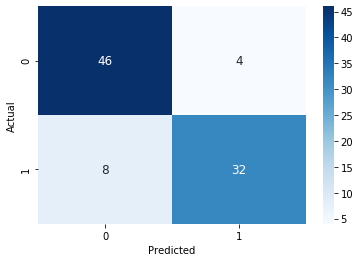

TP: 32, FP: 4, TN: 46, FN: 8
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.852     0.920     0.885        50
           1      0.889     0.800     0.842        40

    accuracy                          0.867        90
   macro avg      0.870     0.860     0.863        90
weighted avg      0.868     0.867     0.866        90

-----------------------------------------------------------
test_size: 0.26
-----------------------------------------------------------
Recall Score: 0.8333
Macro Average of Recall Score: 0.8712
Weighted Average of Recall Score: 0.8763
------------------------------------------------------
Macro Average of Precision Score: 0.8761
Weighted Average of Precision Score: 0.8762
------------------------------------------------------
Macro Average of F1 Score: 0.8733
Weighted Average of F1 Score: 0.8759
---------------------------------------------------------------


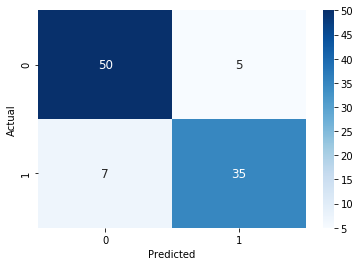

TP: 35, FP: 5, TN: 50, FN: 7
---------------------------------------------------------------
              precision    recall  f1-score   support

           0      0.877     0.909     0.893        55
           1      0.875     0.833     0.854        42

    accuracy                          0.876        97
   macro avg      0.876     0.871     0.873        97
weighted avg      0.876     0.876     0.876        97



In [22]:
test_size = [0.24, 0.26]

for t in test_size:
    
    df = pd.read_csv('preprocessed_oasis_longitudinal.csv')
    df = df. drop('Unnamed: 0', axis=1)

    X = df.drop('CDR', axis = 1) 
    y = df['CDR']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = t, random_state = 0)
    
    # standardizing the data
    
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    model = CatBoostClassifier(logging_level='Silent', random_state = 42)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    
    print ('-----------------------------------------------------------')
    print ('test_size: {}'.format(t))
    print ('-----------------------------------------------------------')

    macro_weighted(y_test, y_hat)
    cm()
    class_rep()

### We choose test_size  = 0.26